In [1]:
from support.df_init import init

train = init()
test = init('pp_test.csv')

In [2]:
train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

In [3]:
import pandas as pd

# Perform one-hot encoding on the 'titleType' feature
train = pd.concat([train, pd.get_dummies(train['titleType'], prefix='titleType')], axis=1)
test = pd.concat([test, pd.get_dummies(test['titleType'], prefix='titleType')], axis=1)

# Drop the original 'titleType' column if no longer needed
train.drop(columns=['titleType'], inplace=True)
test.drop(columns=['titleType'], inplace=True)

In [4]:
train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'awardNominationsExcludeWins', 'canHaveEpisodes',
       'numRegions', 'userReviewsTotal', 'is_Documentary', 'is_History',
       'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi',
       'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music',
       'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action',
       'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',
       'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror',
       'is_Animation', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'countryOfOrigin', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryOfOrigin_AS',
       'countryOfOrigin_EU', 'countryOfOr

# has_lowEngagement

In [5]:
train['has_lowEngagement'] = (train['numVotes'] < 100).astype(int)
test['has_lowEngagement'] = (test['numVotes'] < 100).astype(int)

In [6]:
print("Train has_lowEngagement counts:")
print(train['has_lowEngagement'].value_counts())

print("\nTest has_lowEngagement counts:")
print(test['has_lowEngagement'].value_counts())

Train has_lowEngagement counts:
has_lowEngagement
1    11074
0     5057
Name: count, dtype: int64

Test has_lowEngagement counts:
has_lowEngagement
1    3675
0    1693
Name: count, dtype: int64


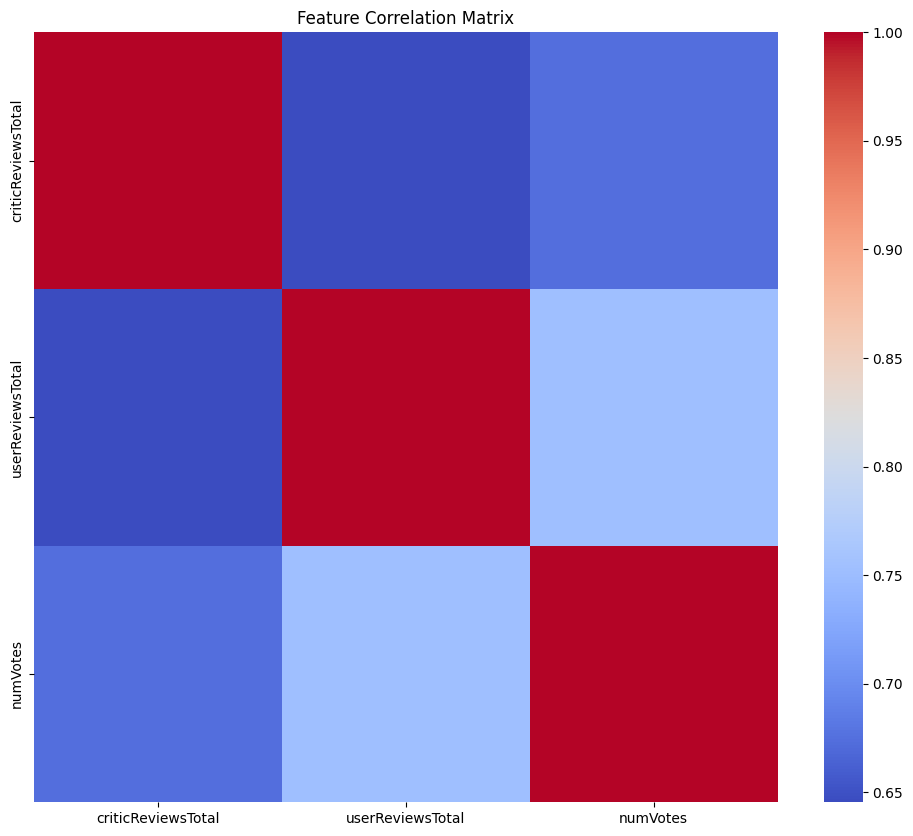

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = train[['criticReviewsTotal', 'userReviewsTotal', 'numVotes']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

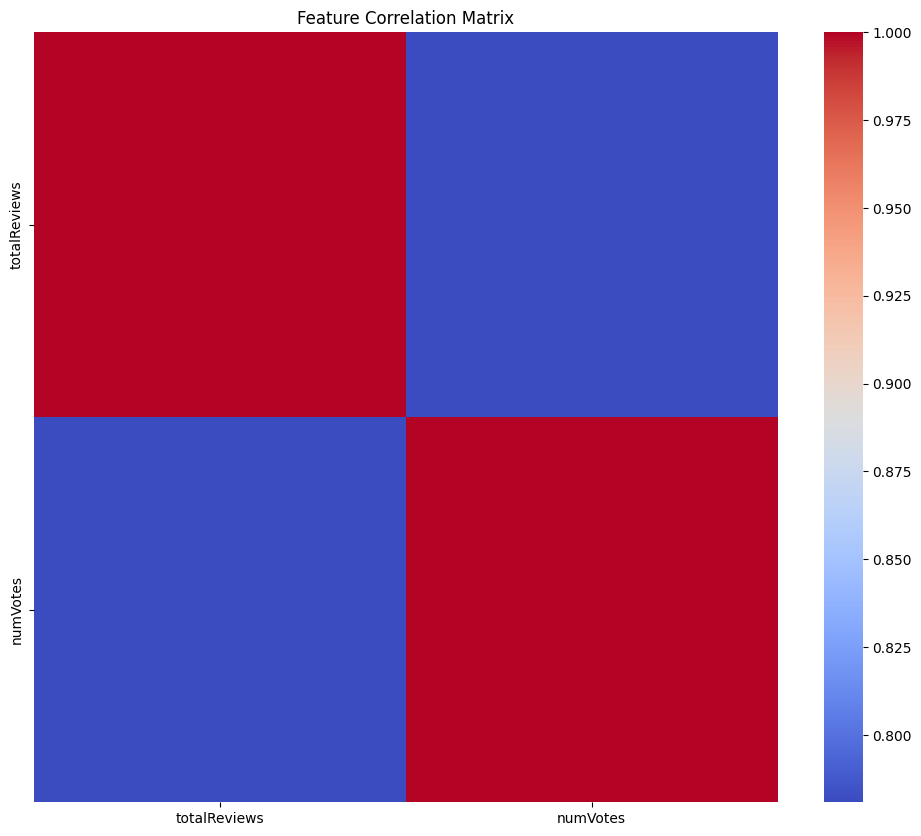

In [8]:
train['totalReviews'] = train['criticReviewsTotal'] + train['userReviewsTotal']

correlation_matrix = train[['totalReviews', 'numVotes']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [9]:
feats = [
    'numRegions',
    'totalMedia',
    'totalCredits', 
    'totalNominations',
    # 'rating',
    'startYear',
    # 'canHaveEpisodes',
    'fill_runtimeMinutes_Bruno',
    # 'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
    # 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
    # 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
    # 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
    # 'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
    # 'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
    'countryOfOrigin_freq_enc',
    # 'countryOfOrigin_NA',
    # 'countryOfOrigin_AF',
    'countryOfOrigin_AS',
    'countryOfOrigin_EU',
    # 'countryOfOrigin_OC',
    # 'countryOfOrigin_SA',
    # 'countryOfOrigin_UNK',
    # 'is_from_Oceania', 'is_from_North America',
    # 'is_from_South America', 'is_from_Asia', 'is_from_Africa',
    # 'is_from_Europe',
    'criticReviewsTotal',
    # 'userReviewsTotal',
    'titleType_movie', 'titleType_short',
    'titleType_tvEpisode',
    # 'titleType_tvMiniSeries',
    # 'titleType_tvMovie',
    'titleType_tvSeries',
    # 'titleType_tvShort',
    # 'titleType_tvSpecial',
    'titleType_video'
]

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Prepare the data
X_train = train.loc[~train['outlier_w_type'], feats].copy()
X_test = test.loc[~test['outlier_w_type'], feats].copy()

# Scale the features
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train = train.loc[~train['outlier_w_type'], 'has_lowEngagement'].copy()
y_test = test.loc[~test['outlier_w_type'], 'has_lowEngagement'].copy()

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': randint(10, 60),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 30),
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': uniform(0.0, 0.05),  # cost-complexity pruning
    'splitter': ['best', 'random']
}

# Initialize the Isolation Forest model
base_clf = DecisionTreeClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_grid,
    n_iter=200,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit Randomized Search to the training data
random_search.fit(X_train, y_train)

# Use the best estimator from random search
clf = random_search.best_estimator_

print(clf)

# Predict anomalies (-1 for anomaly, 1 for normal)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

# Generate classification report
report_train = classification_report(y_train, train_pred)
report_test = classification_report(y_test, test_pred)

print("Classification Report for Train Data:")
print(report_train)
print("\nClassification Report for Test Data:")
print(report_test)

DecisionTreeClassifier(ccp_alpha=0.0007039911357542228, criterion='log_loss',
                       max_depth=26, min_samples_leaf=3, random_state=42)
Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.84      0.65      0.73      4668
           1       0.86      0.94      0.90     10287

    accuracy                           0.85     14955
   macro avg       0.85      0.80      0.82     14955
weighted avg       0.85      0.85      0.85     14955


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.81      0.64      0.72      1561
           1       0.85      0.93      0.89      3416

    accuracy                           0.84      4977
   macro avg       0.83      0.79      0.80      4977
weighted avg       0.84      0.84      0.83      4977



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
clf.feature_importances_

array([0.11161305, 0.11845411, 0.15797709, 0.        , 0.03543654,
       0.01420955, 0.0325919 , 0.        , 0.00421561, 0.4865707 ,
       0.        , 0.00554566, 0.02823169, 0.00253119, 0.00262293])

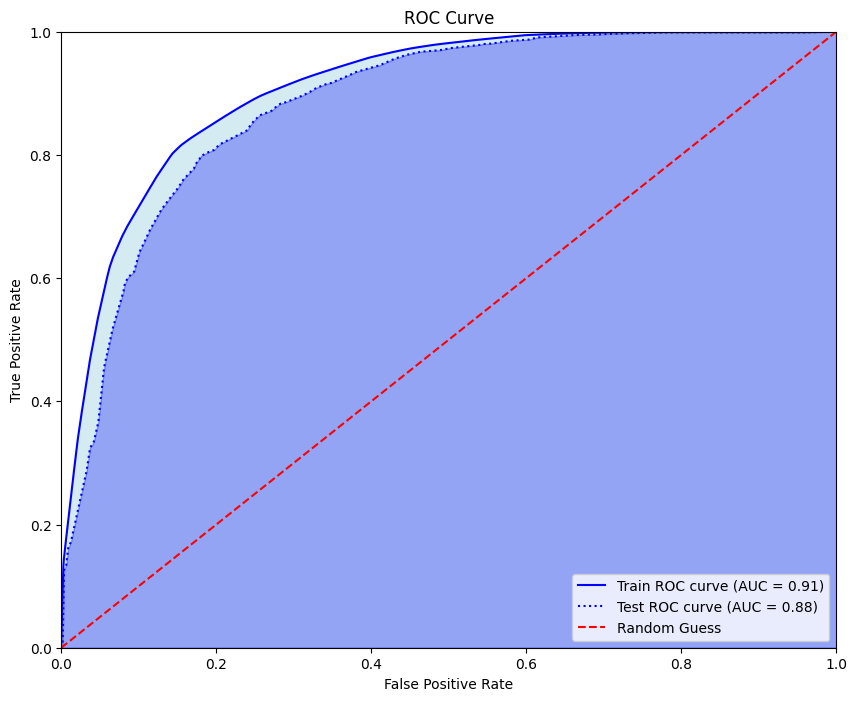

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_train_proba = clf.predict_proba(X_train)[:, 1]
y_test_proba = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for train data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='blue', linestyle='dotted', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.fill_between(fpr_train, tpr_train, alpha=0.5, color='lightblue')
plt.fill_between(fpr_test, tpr_test, alpha=0.3, color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

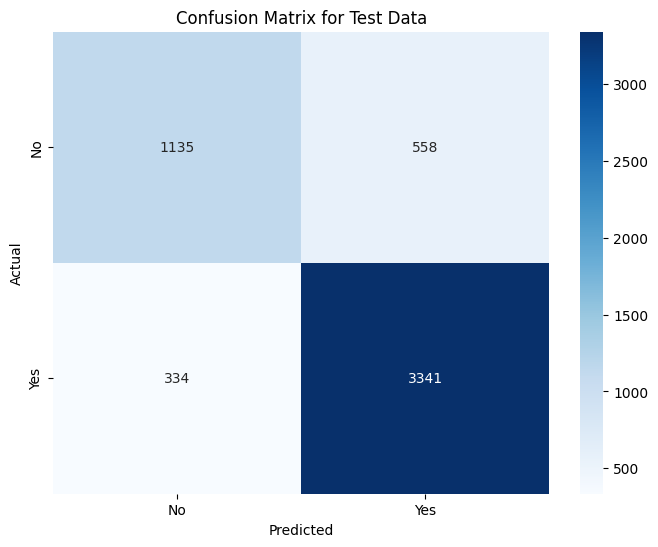

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrices
conf_matrix_train = confusion_matrix(y_train, train_pred)
conf_matrix_test = confusion_matrix(y_test, test_pred)

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

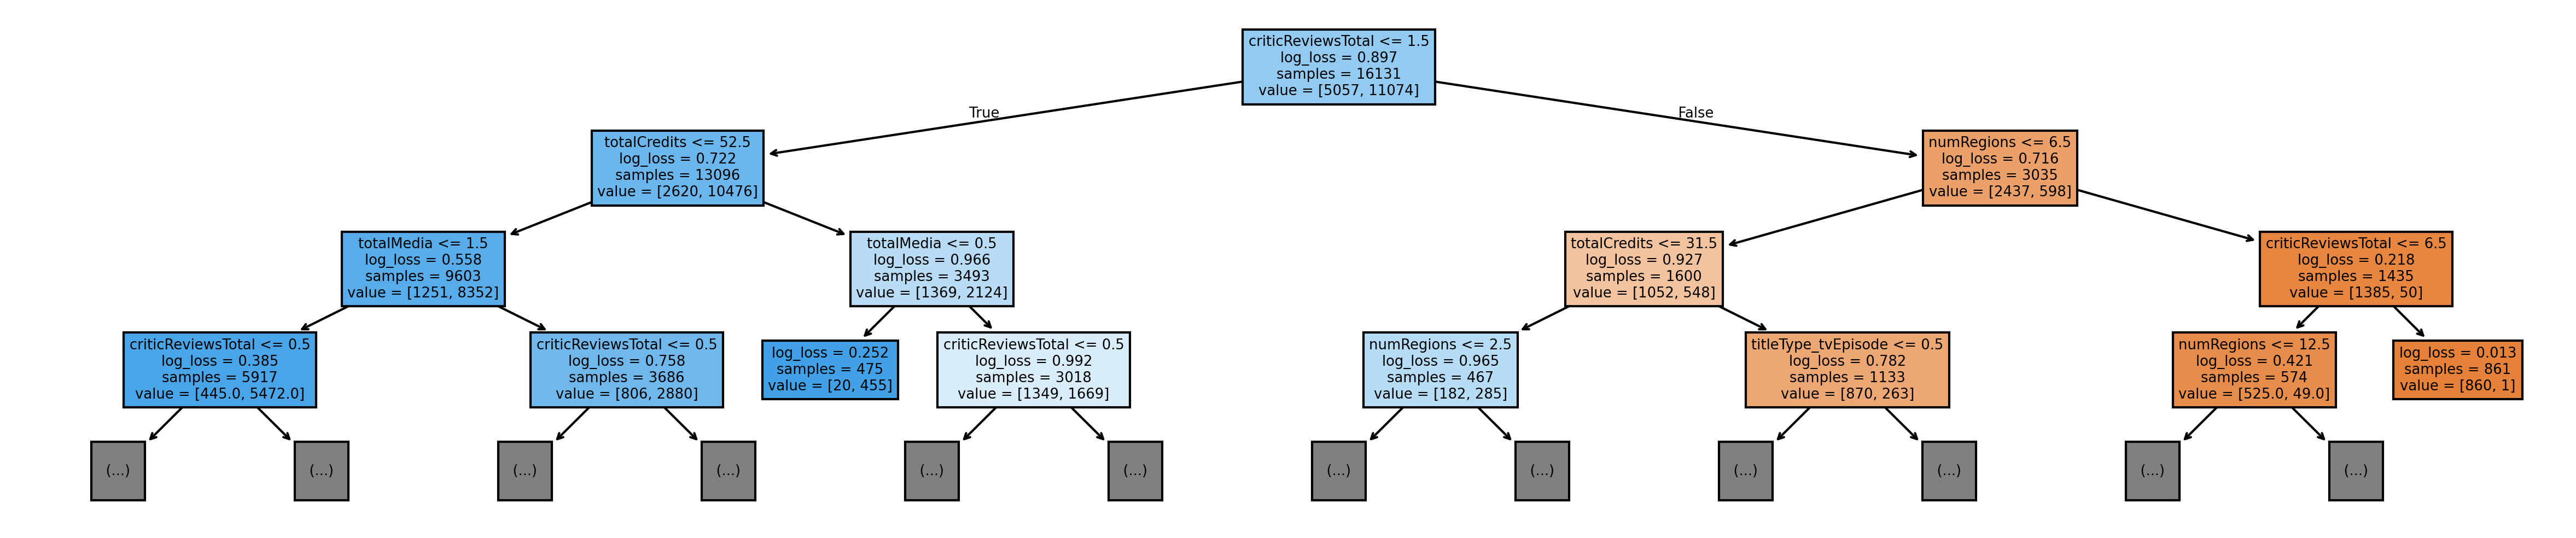

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=feats, filled=True, max_depth=3,)
plt.show()

In [ ]:
from support.outliers import detect_outliers

train, test = detect_outliers(train, test)

runtimeMinutes nan nan


TypeError: impute_outliers() missing 1 required positional argument: 'upper_thresh'

In [ ]:
feats = [
    'numRegions',
    'totalMedia',
    'totalCredits', 
    'totalNominations',
    # 'rating',
    'startYear',
    # 'canHaveEpisodes',
    'fill_runtimeMinutes_Bruno_imputed',
    # 'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
    # 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
    # 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
    # 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
    # 'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
    # 'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
    'countryOfOrigin_freq_enc',
    # 'countryOfOrigin_NA',
    # 'countryOfOrigin_AF',
    'countryOfOrigin_AS',
    'countryOfOrigin_EU',
    # 'countryOfOrigin_OC',
    # 'countryOfOrigin_SA',
    # 'countryOfOrigin_UNK',
    # 'is_from_Oceania', 'is_from_North America',
    # 'is_from_South America', 'is_from_Asia', 'is_from_Africa',
    # 'is_from_Europe',
    'criticReviewsTotal',
    # 'userReviewsTotal',
    'titleType_movie', 'titleType_short',
    'titleType_tvEpisode',
    # 'titleType_tvMiniSeries',
    # 'titleType_tvMovie',
    'titleType_tvSeries',
    # 'titleType_tvShort',
    # 'titleType_tvSpecial',
    'titleType_video'
]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Prepare the data
# X_train = train.loc[~train['outlier'], feats].copy()
# X_test = test.loc[~test['outlier'], feats].copy()
X_train = train[feats].copy()
X_test = test[feats].copy()

# Scale the features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# y_train = train.loc[~train['outlier'], 'has_lowEngagement'].copy()
# y_test = test.loc[~train['outlier'], 'has_lowEngagement'].copy()
y_train = train['has_lowEngagement'].copy()
y_test = test['has_lowEngagement'].copy()

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': randint(10, 60),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 30),
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': uniform(0.0, 0.05),  # cost-complexity pruning
    'splitter': ['best', 'random']
}

# Initialize the Isolation Forest model
base_clf = DecisionTreeClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_grid,
    n_iter=200,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit Randomized Search to the training data
random_search.fit(X_train, y_train)

# Use the best estimator from random search
clf = random_search.best_estimator_

print(clf)

# Predict anomalies (-1 for anomaly, 1 for normal)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

# Generate classification report
# report_train = classification_report(train.loc[~train['outlier'], 'has_lowEngagement'], train_pred)
# report_test = classification_report(test.loc[~test['outlier'],'has_lowEngagement'], test_pred)
report_train = classification_report(train['has_lowEngagement'], train_pred)
report_test = classification_report(test['has_lowEngagement'], test_pred)

print("Classification Report for Train Data:")
print(report_train)
print("\nClassification Report for Test Data:")
print(report_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


DecisionTreeClassifier(ccp_alpha=0.0007039911357542228, criterion='log_loss',
                       max_depth=26, min_samples_leaf=3, random_state=42)
Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      5067
           1       0.87      0.92      0.89     11105

    accuracy                           0.85     16172
   macro avg       0.83      0.80      0.82     16172
weighted avg       0.85      0.85      0.85     16172


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      1698
           1       0.86      0.91      0.88      3686

    accuracy                           0.83      5384
   macro avg       0.81      0.79      0.80      5384
weighted avg       0.83      0.83      0.83      5384

